In [1]:
#Dependencies
import os
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr
import utils.animutils as aniu

%matplotlib inline

In [2]:
#Model Parameters

tanh_model = 0
relu_model = 0
sigmoid_model = 1

#network params
compression = 50
patchsize = 10
patchlen = 10

#training params
batchsize = 100
iterations = 1100
epochs = 5

if(tanh_model):
    noisexsigma = 0
    noisersigma = 0
    minact = 0
    minslo = 0 
    learning_rate = 0.01
    lamb = 1e-5
    model_type = 'tanh'
elif(relu_model):
    noisexsigma = 0 #0.01
    noisersigma = 0 #0.5
    minact = 0
    minslo = 0 
    learning_rate = 0.1
    lamb = 1e-5
    model_type = 'relu'
elif(sigmoid_model):
    #noise
    noisexsigma = 0.001
    noisersigma = 0.01
    minact = 0 
    minslo = 0
    learning_rate = 0.001
    lamb = 1e-4
    model_type = 'sigmoid'
else:
    raise ValueError('No model specified!')

In [3]:
fpath = '/home/vasha/vanHaterenNaturalMovies/vid075'
fps = 25 #approximated from http://redwood.berkeley.edu/bruno/data/vid075/README and increased by me.
nframes = 9600
rawframeh = 128
rawframew = 128
barw = 16
framew = rawframew - barw #in pixels
frameh = rawframeh - barw #in pixels

#convert to degrees
ppd = 6 #pixels per degree subtended on retina (estimated 10deg for 64px in dong atick 95)
framewdeg = framew/ppd 
framehdeg = frameh/ppd
#sampling rate
deltawdeg = 1./ppd
deltahdeg = 1./ppd 
deltathz = 1./fps


In [164]:
m = plu.qqreadMov(fpath, nframes, rawframeh, rawframew, barw, patch_edge_size=patchsize, time_size=patchlen, normalize_patch=True)
np.random.shuffle(m)
np.shape(m)

(9600, 112, 112)
making patches...
(11, 9600, 112, 10)
(11, 11, 9600, 10, 10)
(960, 11, 11, 10, 10, 10)
(116160, 10, 10, 10)
normalizing patches...


(116160, 10, 10, 10)

In [165]:
#load in movie
try:
    m
except NameError:
    print("Loading Movie...")
    m = readMov(fpath, nframes, rawframeh, rawframew, barw, patch_edge_size=patchsize, time_size=patchlen, normalize_patch=True)
    np.random.shuffle(m)
    #mm = m - np.mean(m,axis=(1,2)).reshape(-1,1,1)
    
print("Movie Loaded. Shape is "+str(np.shape(m)))

Movie Loaded. Shape is (116160, 10, 10, 10)


In [166]:
#params of clips
imxlen = len(m[0,:,0,0])
imylen = len(m[0,0,:,0])
imflen = len(m[0,0,0,:])
nimages = len(m[:,0,0,0])

nimstrained = batchsize * iterations

if(nimstrained > nimages):
    print('ERROR! Trying to train',nimstrained,'patchess, but we only have',nimages,'patches!')
else:
    print('Training',nimstrained,'out of',nimages,'total patches.')

Training 110000 out of 116160 total patches.


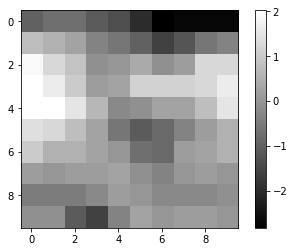

In [167]:
## show an example image
plt.imshow(m[274,:,:,1],cmap='gray',interpolation='none')
plt.colorbar()

In [168]:
nneurons = np.int(imxlen*imylen*imflen/compression)
print('Compressing by',compression,'for a total of',nneurons,'neurons')
savefolder = str('./output_movieac/actfun_'+model_type+'/neurons_'+str(nneurons)+'/noise_in_'+str(noisexsigma)+'_out_'+str(noisersigma)+'_lambda_'+str(lamb)+'/')
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

#setup our graph
    
#input image
x = tf.placeholder(tf.float32, shape=(batchsize,imxlen*imylen*imflen),name='input_patch')

#activation function type
act_fun = tf.placeholder(tf.string, name= 'activation_function')

#noise
nxc = noisexsigma**2
nrc = noisersigma**2
nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='internal_noise')

#weights
win = tf.Variable(tf.random_normal([imxlen*imylen*imflen,nneurons],dtype=tf.float32,stddev=0.1),name='weights_in')
#wout = tf.Variable(tf.random_normal([nneurons,imxlen*imylen],dtype=tf.float32,stddev=0.01),name='weights_out')

#bias
bias = tf.Variable(tf.random_normal([nneurons],dtype=tf.float32,stddev=0.1),name='bias')

#define nonlinearities
def tanh_fun(arg):
    return tf.nn.tanh(arg) 
def sigmoid_fun(arg):
    return tf.nn.sigmoid(arg) 
def relu_fun(arg):
    return tf.nn.relu(arg) 
def no_fun(arg):
    return arg

#calculate input
linearin = tf.add(tf.matmul(tf.add(x,nx),win),bias)
yin = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearin)),
               tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearin)),
               tf.equal(act_fun,'relu'): (lambda: relu_fun(linearin))},
              default=(lambda: no_fun(linearin)),
              exclusive=True, name = 'input_nonlinearity')

#calculate output
linearout = tf.matmul(yin,tf.transpose(win))
yout = tf.case({tf.equal(act_fun,'tanh'): (lambda: tanh_fun(linearout)),
                tf.equal(act_fun,'sigmoid'): (lambda: sigmoid_fun(linearout)),
                tf.equal(act_fun,'relu'): (lambda: relu_fun(linearout))},
               default=(lambda: no_fun(linearout)),
               exclusive=True, name='output_nonlienarity')

#calculate reconstruction
xp = tf.add(yout,nr)

#calculate cost
cost = tf.sqrt(tf.reduce_mean(tf.square(x-xp))) - tf.reduce_sum(tf.abs(yin*lamb))

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Compressing by 50 for a total of 20 neurons


In [169]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    cost_evolution = []
    wmean_evolution = []
    
    weights_evolution = []
    images = []
    recons = []
    
    #train over niterations
    nits = iterations #full run
    
    print('Training {} iterations in {} epochs...'.format(nits, epochs))
    for epoch in range(epochs):
        print('\nEpoch {}: '.format(epoch+1))
        np.random.shuffle(m)
        for ii in range(nits):
            clip = np.reshape(m[ii*batchsize:(1+ii)*batchsize,:,:,:],(batchsize,-1)).astype(np.float32)
            #print(np.shape(clip))
            sess.run(train_step, feed_dict={x:clip, act_fun:model_type})

            #save evolution of params
            objcost, wmean = sess.run([cost,win], feed_dict={x:clip, act_fun:model_type})
            cost_evolution.append(objcost)
            wmean_evolution.append(np.mean(wmean))
            
            if(ii%(int((nits*epochs)/100))==0):
                print(str(ii)+', ',end="")
                #dump our weights
                w = sess.run(win, feed_dict={x:clip, act_fun:model_type})
                weights_evolution.append(np.reshape(w,(imxlen,imylen,imflen,nneurons)))
                #and save our image and reconstruction
                images.append(np.reshape(clip,[batchsize,imxlen,imylen,imflen]))
                recons.append(np.reshape(sess.run(xp, feed_dict={x:clip, act_fun:model_type}),[batchsize,imxlen,imylen,imflen]))
                
    
    final_weights = sess.run(win, feed_dict={x:clip, act_fun:model_type})
    print('\nDone!')

Training 1100 iterations in 5 epochs...

Epoch 1: 
0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 715, 770, 825, 880, 935, 990, 1045, 
Epoch 2: 
0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 715, 770, 825, 880, 935, 990, 1045, 
Epoch 3: 
0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 715, 770, 825, 880, 935, 990, 1045, 
Epoch 4: 
0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 715, 770, 825, 880, 935, 990, 1045, 
Epoch 5: 
0, 55, 110, 165, 220, 275, 330, 385, 440, 495, 550, 605, 660, 715, 770, 825, 880, 935, 990, 1045, 
Done!


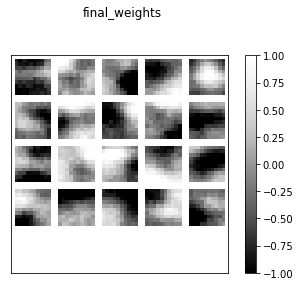

In [170]:
#Show our final weights
#wr = np.rollaxis(np.reshape(final_weights,(imxlen,imylen,nneurons)),2)
#im = plu.display_data_tiled(wr, normalize=False, title="final_weights", prev_fig=None)

#Show our final weights
#print(np.shape(weights_evolution))
#print(np.shape(np.reshape(weights_evolution,(len(weights_evolution),imxlen,imylen,imflen,nneurons))))
weights_evolution_r = np.rollaxis(np.array(weights_evolution),4,1)
my_final_weights = weights_evolution_r[-1]
#print(my_final_weights.shape)
#print(np.shape(final_weights[1,:,:,:]))
(f,sa,ai) = plu.display_data_tiled(my_final_weights[:,:,:,1], normalize=False, title="final_weights", prev_fig=None)
f.savefig(savefolder+'weights_final.png') 

(<matplotlib.figure.Figure at 0x7fd004337898>,
 <matplotlib.image.AxesImage at 0x7fd00a9c1d68>)

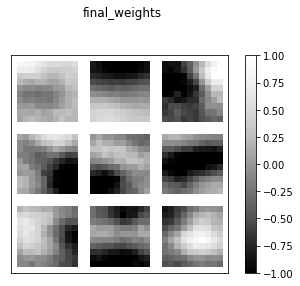

In [171]:
#cluster them
from sklearn.cluster import KMeans

n_clusters = 9
model = KMeans(n_clusters)
orig_shape = my_final_weights.shape

final_shape = [n_clusters]
final_shape.extend(orig_shape[1:])

model.fit(my_final_weights.reshape(nneurons,-1))

avgs = model.cluster_centers_.reshape(final_shape)

# print(model.labels_) #how did we cluster each neuron?

# plt.plot(avgs.T);

plu.display_data_tiled(avgs[:,:,:,1], normalize=False, title="final_weights", prev_fig=None)

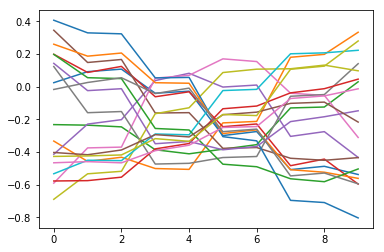

In [172]:
#averaged data
plt.plot(my_final_weights.mean(2).mean(1)[1:30].T);

[3 0 1 4 0 2 0 2 4 3 1 0 0 0 5 4 5 5 0 1]


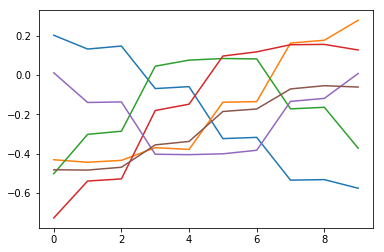

In [173]:
#cluster them
from sklearn.cluster import KMeans

model = KMeans(6)
model.fit(my_final_weights.mean(2).mean(1))

avgs = model.cluster_centers_

print(model.labels_) #how did we cluster each neuron?

plt.plot(avgs.T);

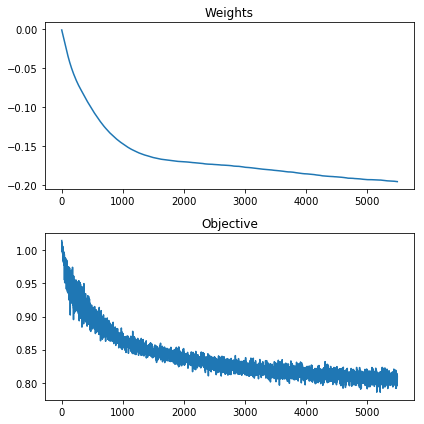

In [174]:
f2 = plt.figure(figsize=(6,6))

plt.subplot(2,1,1,title='Weights')
plt.plot(wmean_evolution)

plt.subplot(2,1,2,title='Objective')
plt.plot(cost_evolution)

plt.tight_layout()

f2.savefig(savefolder+'/cost_weights.png') 

In [175]:
np.shape(images)
np.shape(recons)
#np.shape(weights_evolution_r)

(100, 100, 10, 10, 10)

/home/vasha/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


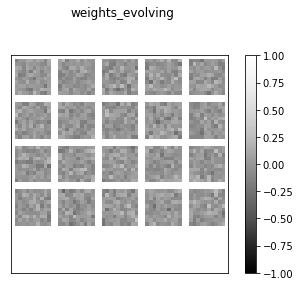

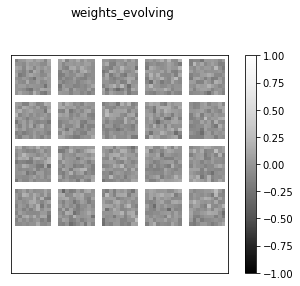

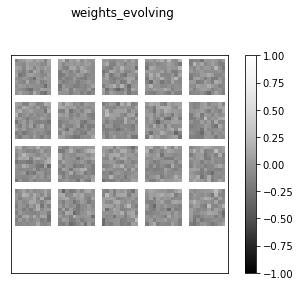

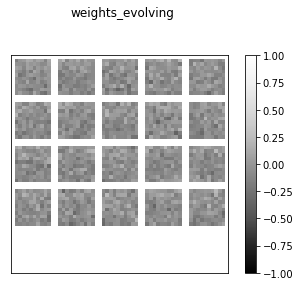

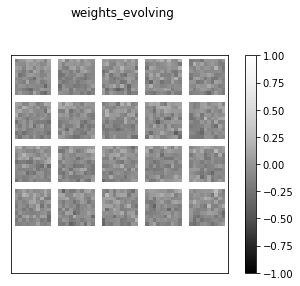

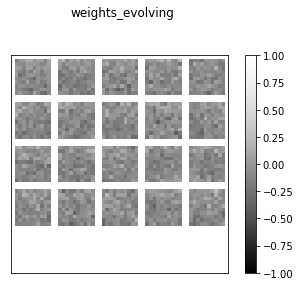

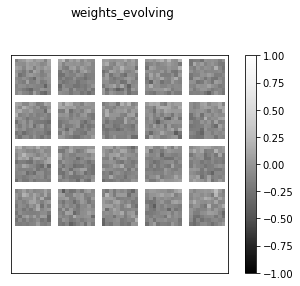

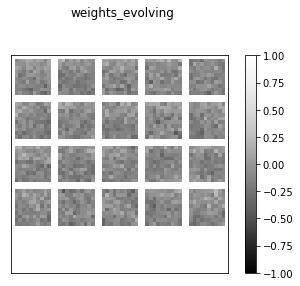

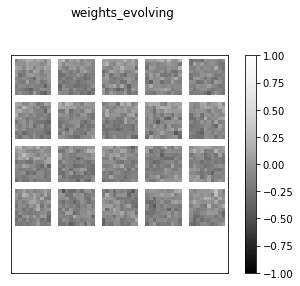

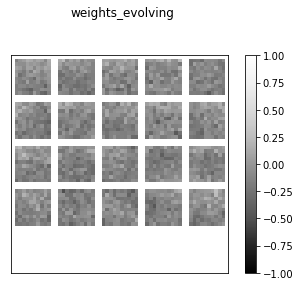

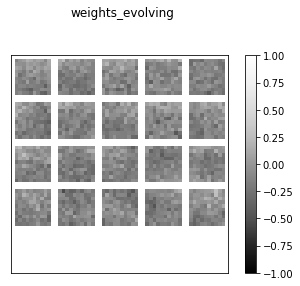

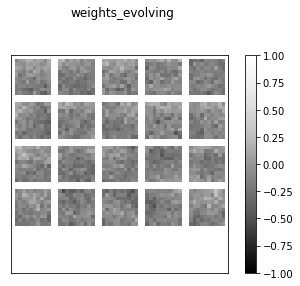

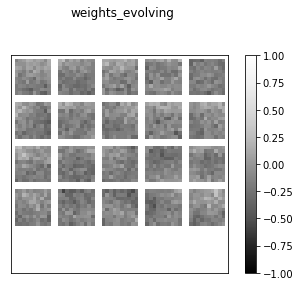

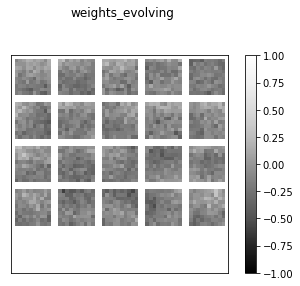

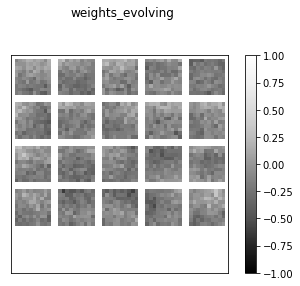

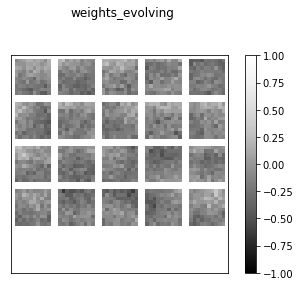

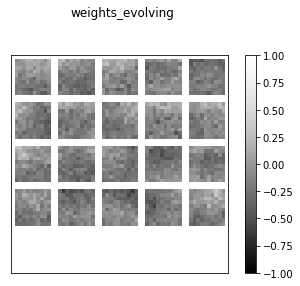

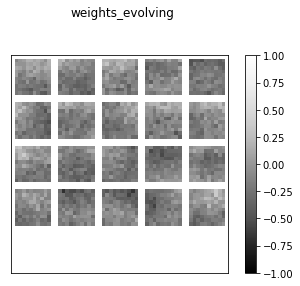

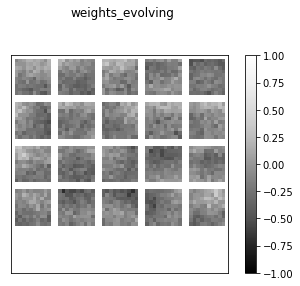

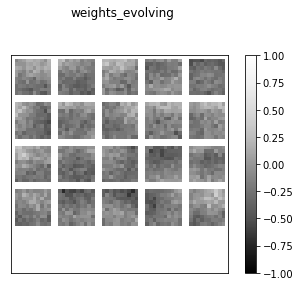

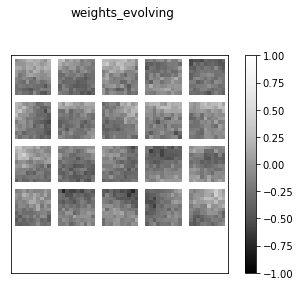

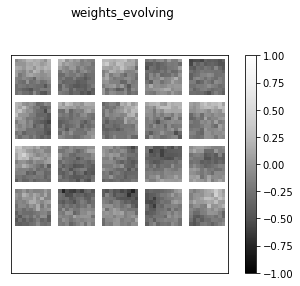

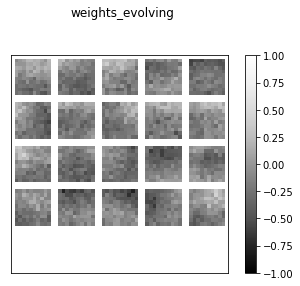

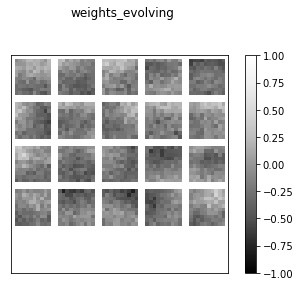

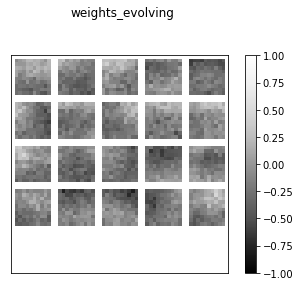

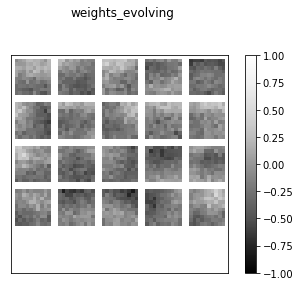

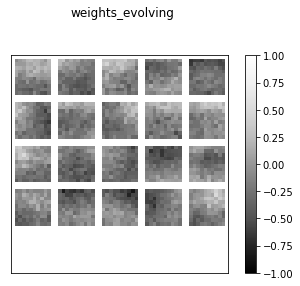

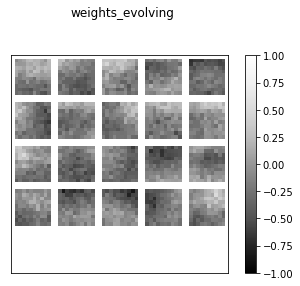

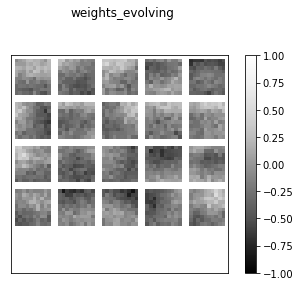

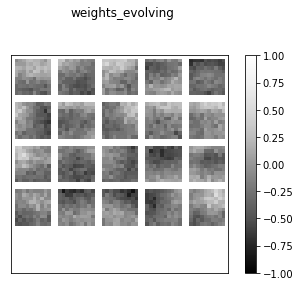

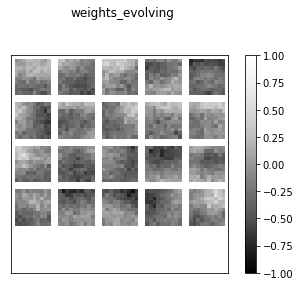

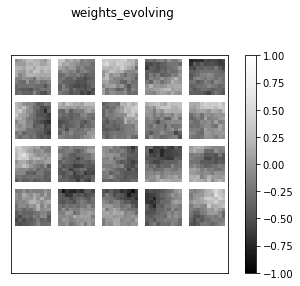

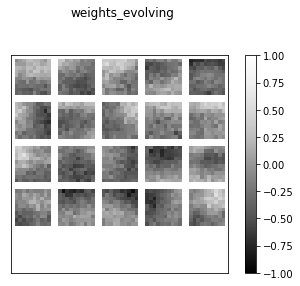

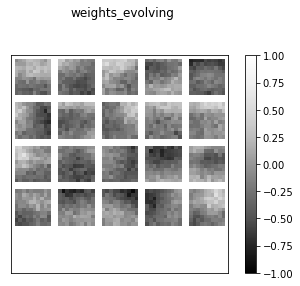

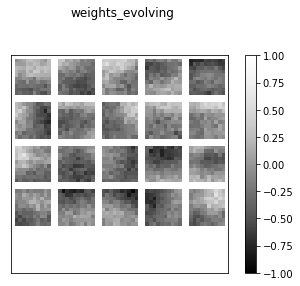

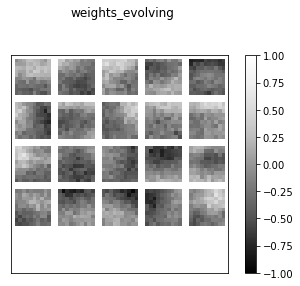

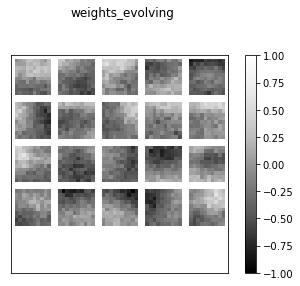

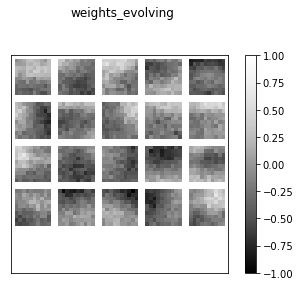

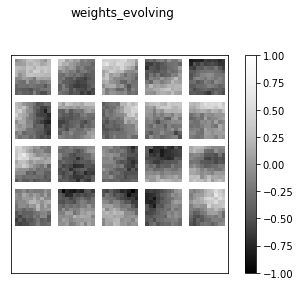

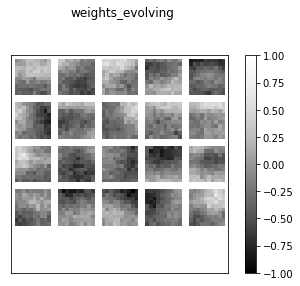

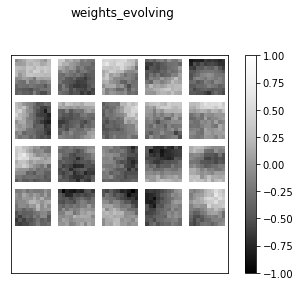

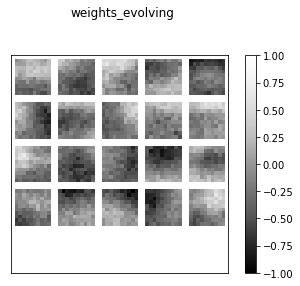

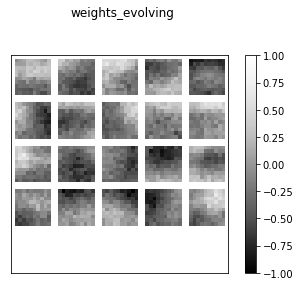

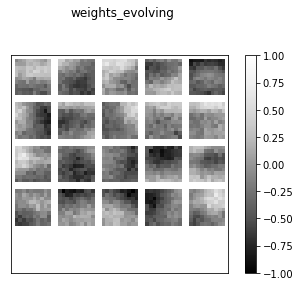

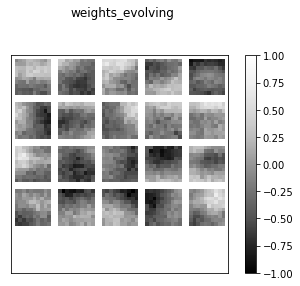

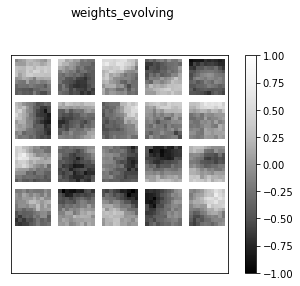

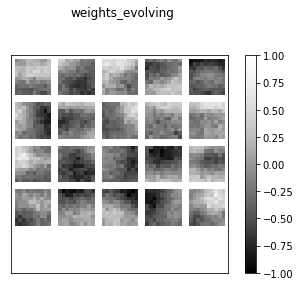

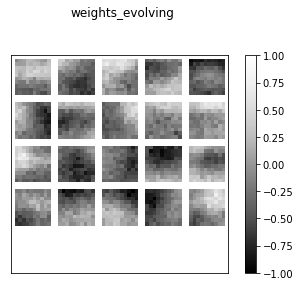

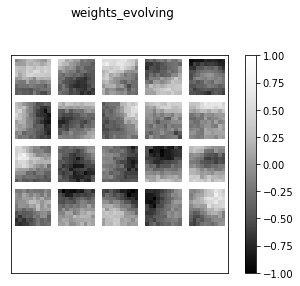

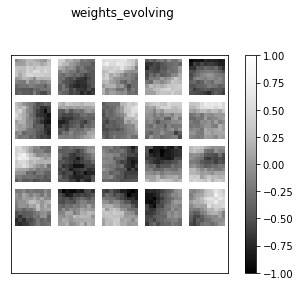

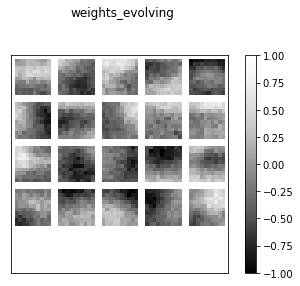

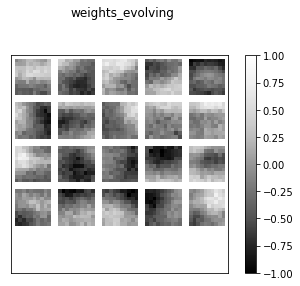

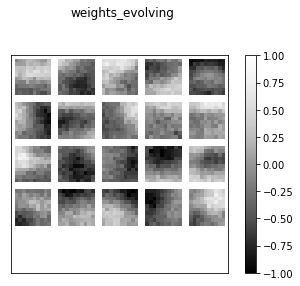

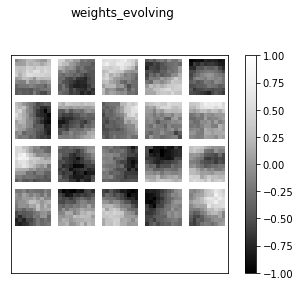

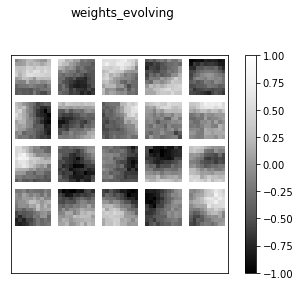

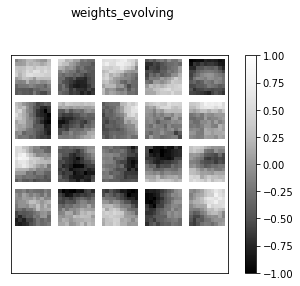

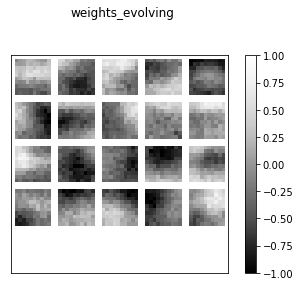

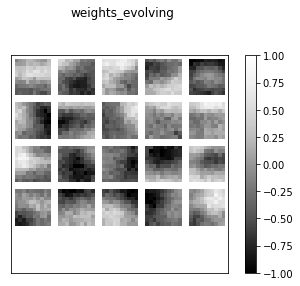

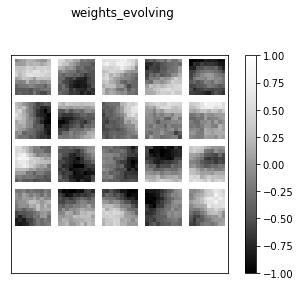

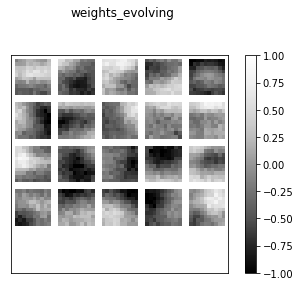

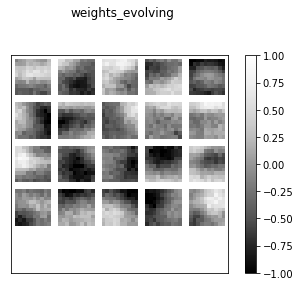

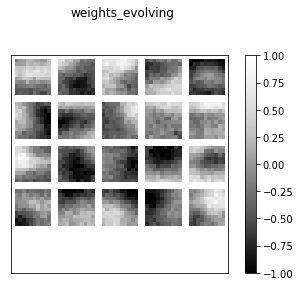

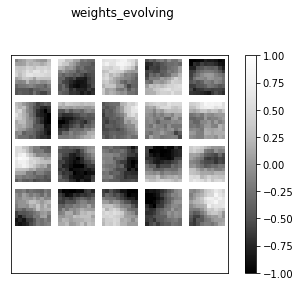

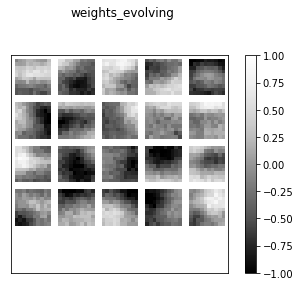

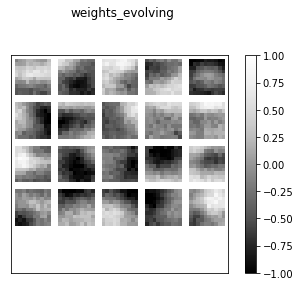

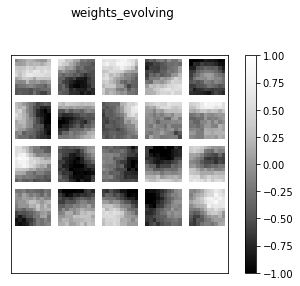

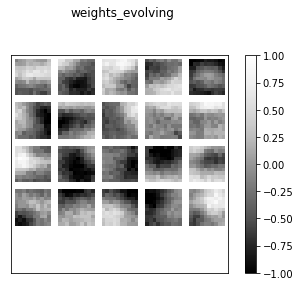

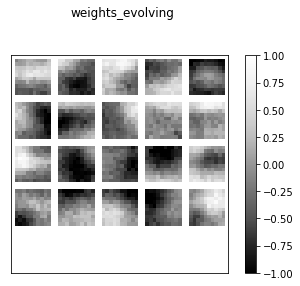

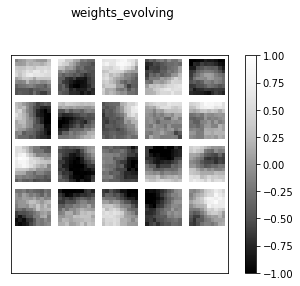

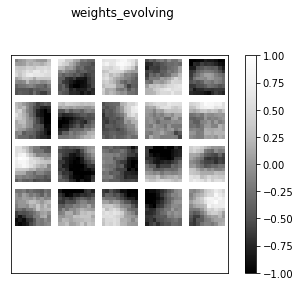

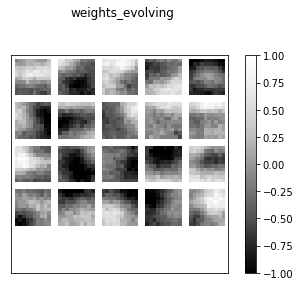

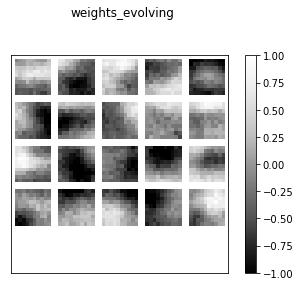

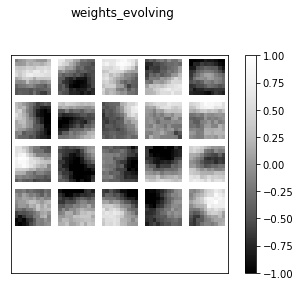

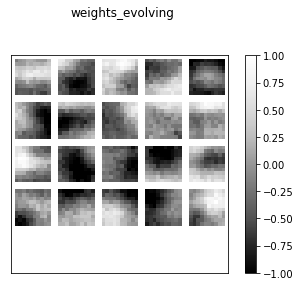

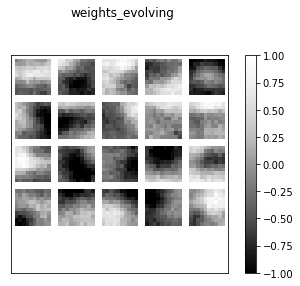

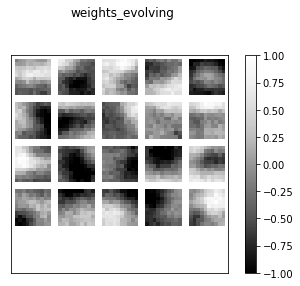

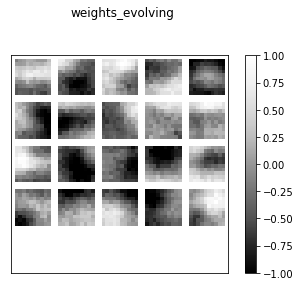

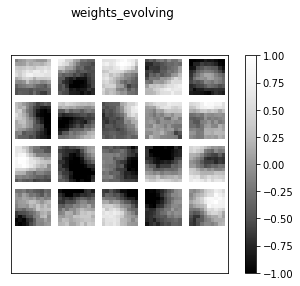

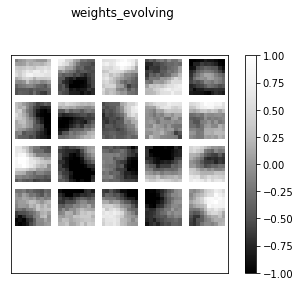

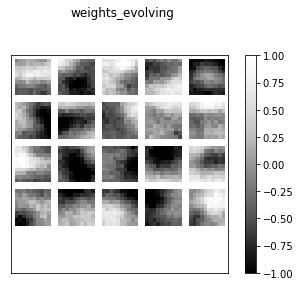

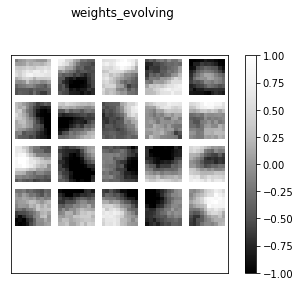

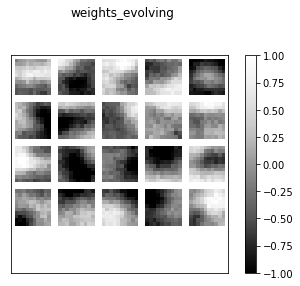

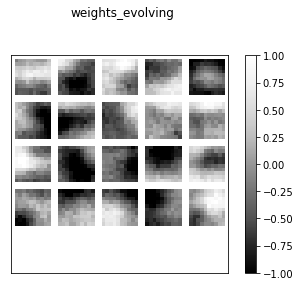

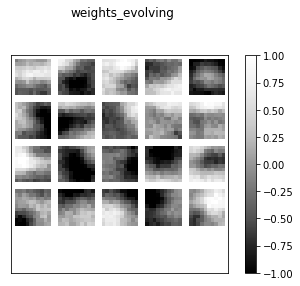

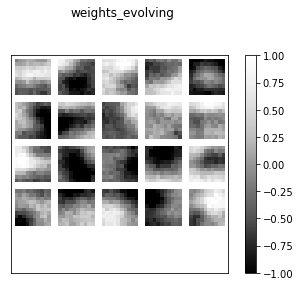

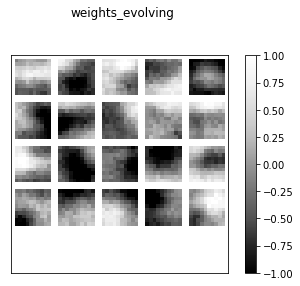

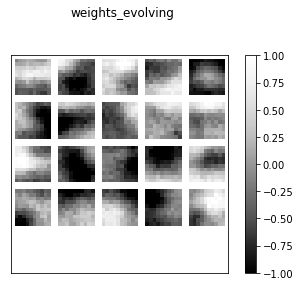

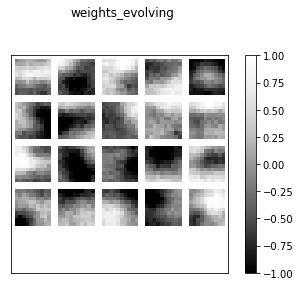

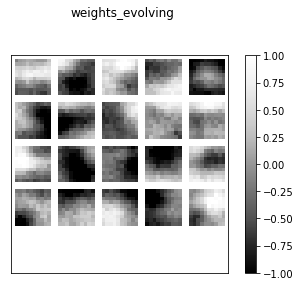

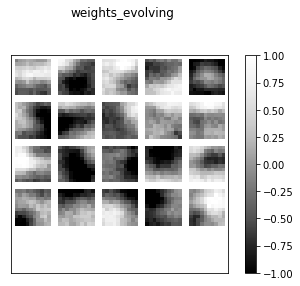

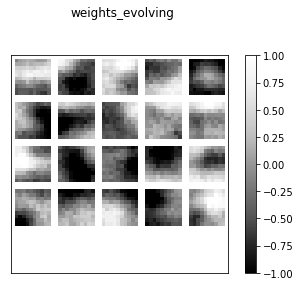

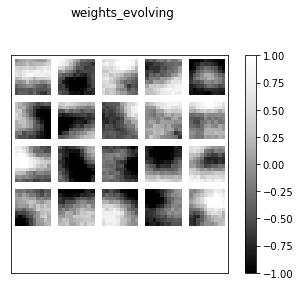

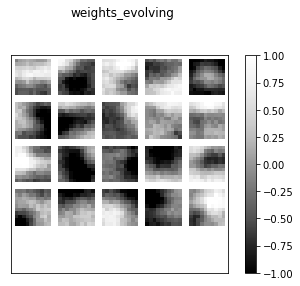

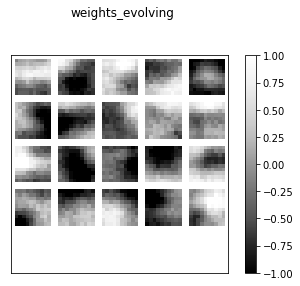

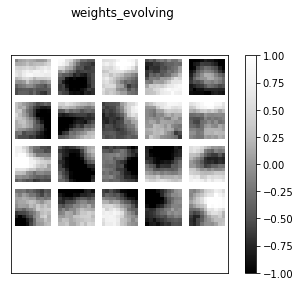

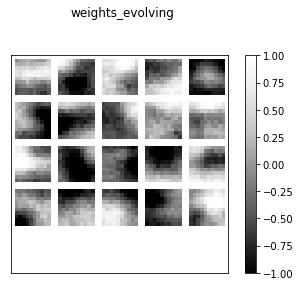

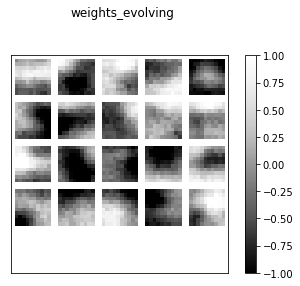

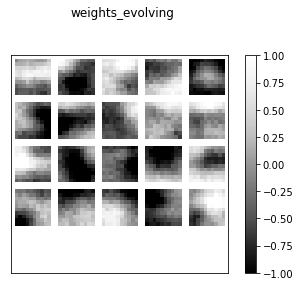

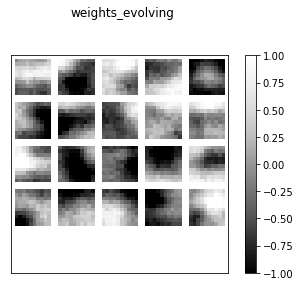

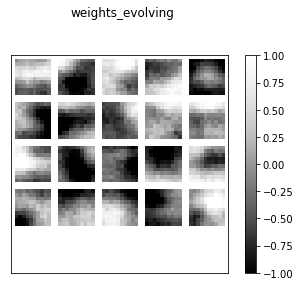

In [176]:
#save figures
for i in range(len(weights_evolution_r)):
    (f,sa,ai) = plu.display_data_tiled(weights_evolution_r[i,:,:,:,-1], normalize=False,title="weights_evolving", prev_fig=None)
    f.savefig(savefolder+'/weights_evolution_'+str(i)+'.png') 

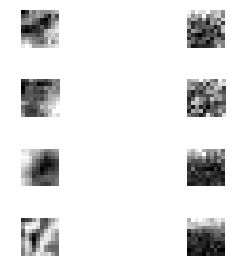

In [177]:
#show an example image and reconstruction from the last iteration of learning
patchnum = 3

plots = 4
for i in range(plots):
    plt.subplot(plots,2,2*i+1)#,title='Patch')
    plt.imshow(images[patchnum+i][-1][:,:,1],cmap='gray',interpolation='none')
    plt.axis('off')
    
    plt.subplot(plots,2,2*i+2)#,title='Recon')
    plt.imshow(recons[patchnum+i][-1][:,:,1],cmap='gray',interpolation='none')
    plt.axis('off')


plt.tight_layout()
plt.savefig(savefolder+'/reconstruction.png') 